In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")


import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

In [2]:
df_whole = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
df_whole.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [3]:
iceland_df = df_whole[df_whole['Country'] == 'Iceland']

In [4]:
iceland_df.shape

(3239, 4)

In [5]:
iceland_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
240456,1743-11-01,-1.794,2.64,Iceland
240457,1743-12-01,NaN,NaN,Iceland
240458,1744-01-01,NaN,NaN,Iceland
240459,1744-02-01,NaN,NaN,Iceland
240460,1744-03-01,NaN,NaN,Iceland


In [6]:
iceland_df.isna().sum()

dt                                0
AverageTemperature               73
AverageTemperatureUncertainty    73
Country                           0
dtype: int64

In [7]:
iceland_df = iceland_df.fillna(1)

In [8]:
iceland_df.isna().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
dtype: int64

In [9]:
iceland_df.shape

(3239, 4)

In [10]:
iceland_df.to_csv('iceland_temps.csv', index=False)

In [11]:
iceland_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
240456,1743-11-01,-1.794,2.64,Iceland
240457,1743-12-01,1.000,1.00,Iceland
240458,1744-01-01,1.000,1.00,Iceland
240459,1744-02-01,1.000,1.00,Iceland
240460,1744-03-01,1.000,1.00,Iceland


In [12]:
#start of splintered func code

iceland_df['dt'] = pd.to_datetime(iceland_df['dt'], infer_datetime_format = True)

In [13]:
iceland_df = iceland_df.set_index('dt')
iceland_df = iceland_df.sort_index()

In [14]:
iceland_df.head()

,AverageTemperature,AverageTemperatureUncertainty,Country
dt,,,
1743-11-01,-1.794,2.64,Iceland
1743-12-01,1.000,1.00,Iceland
1744-01-01,1.000,1.00,Iceland
1744-02-01,1.000,1.00,Iceland
1744-03-01,1.000,1.00,Iceland


In [15]:
iceland_resamp = iceland_df.drop(columns = ['AverageTemperatureUncertainty', 'Country'])

In [16]:
iceland_resamp.head()

,AverageTemperature
dt,
1743-11-01,-1.794
1743-12-01,1.000
1744-01-01,1.000
1744-02-01,1.000
1744-03-01,1.000


In [17]:
# set train size to be 50% of total 
train_size = int(round(iceland_resamp.shape[0] * 0.5))
train_size

1620

In [18]:
# set validate size to be 30% of total 
validate_size = int(round(iceland_resamp.shape[0] * 0.3))
validate_size

972

In [19]:
# set test size to be number of rows remaining. 
test_size = int(round(iceland_resamp.shape[0] * 0.2))
test_size

648

In [20]:
len(iceland_resamp) == train_size + validate_size + test_size

False

In [21]:
validate_end_index = train_size + validate_size
validate_end_index

2592

In [22]:
train = iceland_resamp[:train_size]

In [23]:
train.tail()

,AverageTemperature
dt,
1878-06-01,6.925
1878-07-01,8.766
1878-08-01,8.048
1878-09-01,4.348
1878-10-01,-0.068


In [24]:
validate = iceland_resamp[train_size:validate_end_index]

In [25]:
validate.head()

,AverageTemperature
dt,
1878-11-01,-3.236
1878-12-01,-7.242
1879-01-01,-2.463
1879-02-01,-4.469
1879-03-01,-4.317


In [26]:
validate.tail()

,AverageTemperature
dt,
1959-06-01,6.363
1959-07-01,8.486
1959-08-01,7.428
1959-09-01,6.351
1959-10-01,4.322


In [27]:
test = iceland_resamp[validate_end_index:]

In [28]:
test.head()

,AverageTemperature
dt,
1959-11-01,-1.235
1959-12-01,-2.204
1960-01-01,-1.922
1960-02-01,-4.115
1960-03-01,-0.448


In [29]:
train.shape[0], validate.shape[0], test.shape[0]

(1620, 972, 647)

In [30]:
len(train) + len(validate) + len(test) == len(iceland_resamp)

True

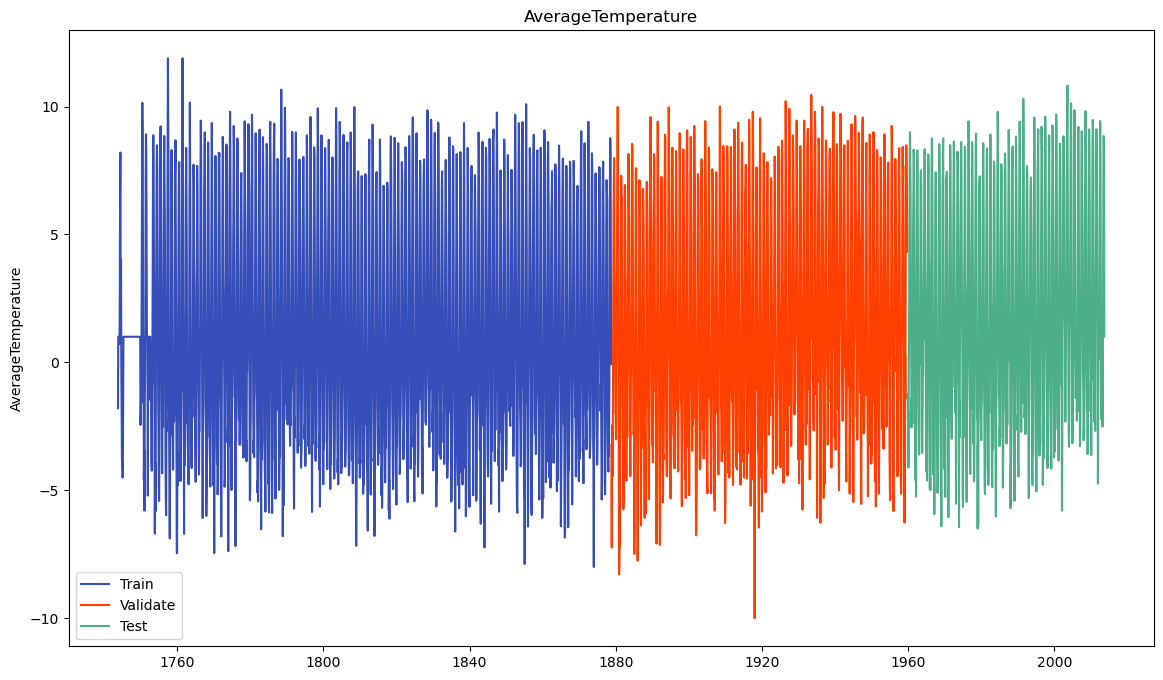

In [98]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#354eb8', label = 'Train')
    plt.plot(validate[col], color='#ff3f00', label = 'Validate')
    plt.plot(test[col], color='#4daf8a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

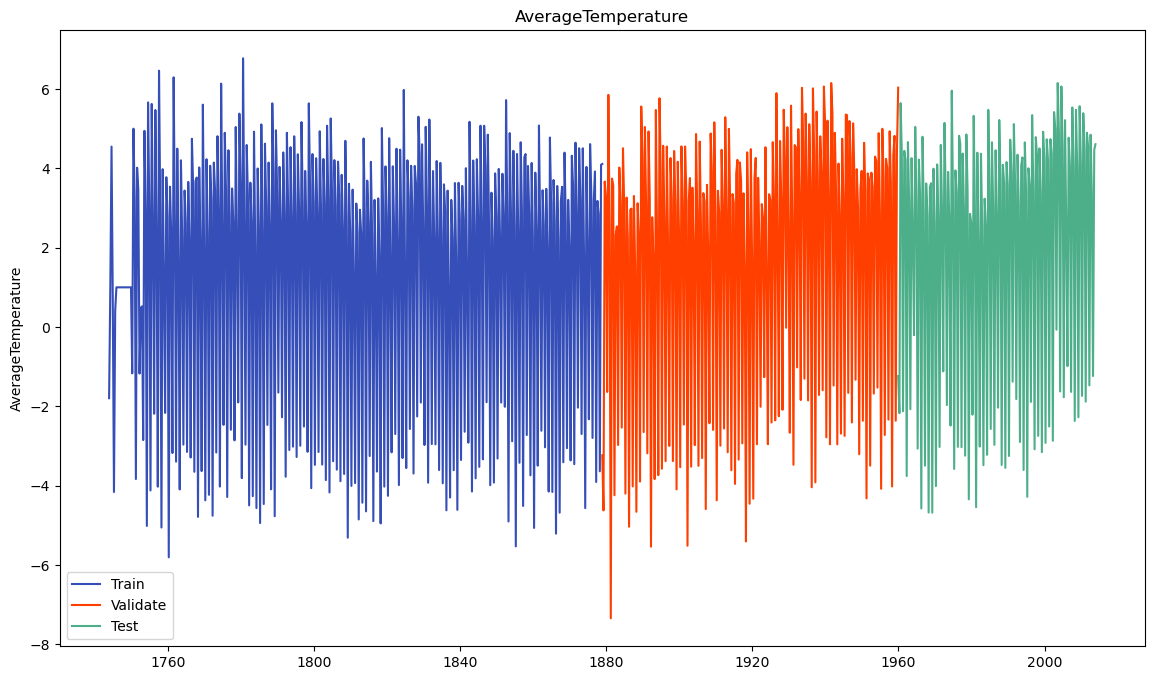

In [178]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train.resample('4m')[col].mean(), color='#354eb8', label = 'Train')
    plt.plot(validate.resample('4m')[col].mean(), color='#ff3f00', label = 'Validate')
    plt.plot(test.resample('4m')[col].mean(), color='#4daf8a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [32]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [33]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [34]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [35]:
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [36]:
#moving average baseline
period=365
train['AverageTemperature'].rolling(period).mean()

dt
1743-11-01         NaN
1743-12-01         NaN
1744-01-01         NaN
1744-02-01         NaN
1744-03-01         NaN
                ...   
1878-06-01    1.077586
1878-07-01    1.117600
1878-08-01    1.146940
1878-09-01    1.166310
1878-10-01    1.158214
Name: AverageTemperature, Length: 1620, dtype: float64

In [37]:
train['AverageTemperature'].rolling(period).mean()[-1]

1.158213698630137

In [38]:
rolling_temp = round(train['AverageTemperature'].rolling(period).mean()[-1], 2)


In [39]:
def make_baseline_predictions(temp_predictions):
    yhat_df = pd.DataFrame({'AverageTemperature': [temp_predictions]},
                          index=validate.index)
    return yhat_df

In [40]:
yhat_df = make_baseline_predictions(rolling_temp)
yhat_df.head()

,AverageTemperature
dt,
1878-11-01,1.16
1878-12-01,1.16
1879-01-01,1.16
1879-02-01,1.16
1879-03-01,1.16


AverageTemperature -- RMSE: 5


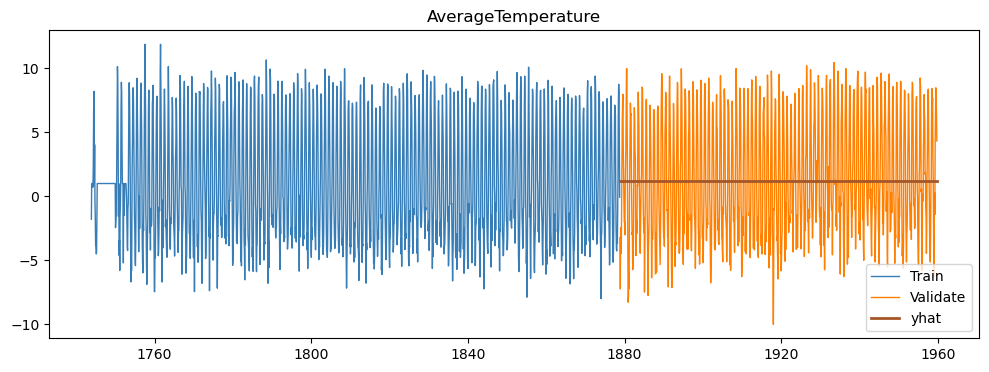

In [41]:
for col in train.columns:
    plot_and_eval(col)

In [42]:
for col in train.columns:
    eval_df = append_eval_df(model_type='moving_avg', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,moving_avg,AverageTemperature,5.0


In [43]:
avg_temp = round(train['AverageTemperature'].mean(), 2)
avg_temp

1.14

In [44]:
yhat_df = make_baseline_predictions(avg_temp)

In [45]:
yhat_df.head()

,AverageTemperature
dt,
1878-11-01,1.14
1878-12-01,1.14
1879-01-01,1.14
1879-02-01,1.14
1879-03-01,1.14


AverageTemperature -- RMSE: 5


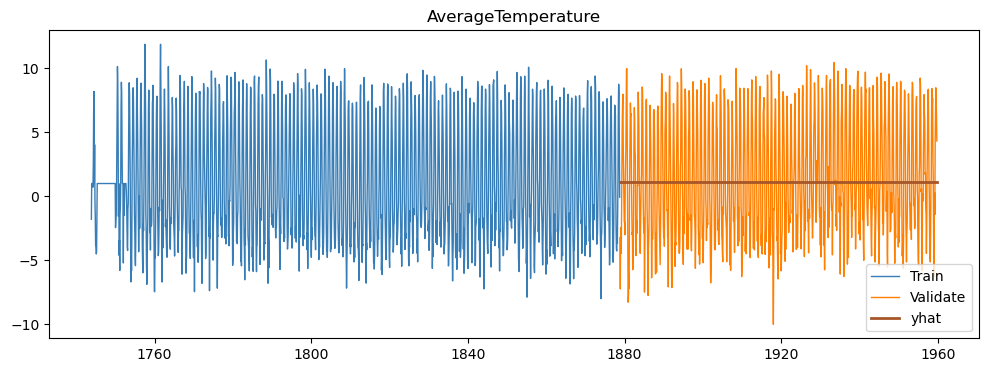

In [46]:
for col in train.columns:
    plot_and_eval(col)

In [47]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,moving_avg,AverageTemperature,5.0
1,simple_average,AverageTemperature,5.0


In [48]:
periods = [7, 30, 90, 120, 730]

for p in periods: 
    rolling_temp = round(train['AverageTemperature'].rolling(p).mean()[-1], 2)
    yhat_df = make_baseline_predictions(rolling_temp)
    model_type = str(p) + '_day_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [49]:
eval_df

,model_type,target_var,rmse
0,moving_avg,AverageTemperature,5.0
1,simple_average,AverageTemperature,5.0
2,7_day_moving_avg,AverageTemperature,5.0
3,30_day_moving_avg,AverageTemperature,5.0
4,90_day_moving_avg,AverageTemperature,5.0
5,120_day_moving_avg,AverageTemperature,5.0
6,730_day_moving_avg,AverageTemperature,5.0


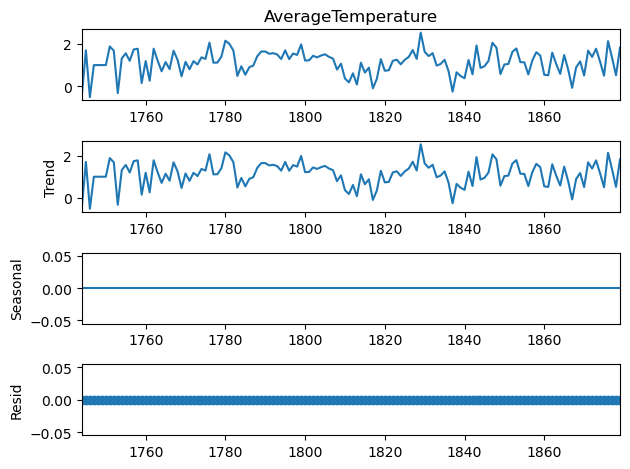

In [52]:
sm.tsa.seasonal_decompose(train['AverageTemperature'].resample('1y').mean()).plot()
None

In [51]:
np.isfinite(train['AverageTemperature']).sum()

1620

In [62]:
col = 'AverageTemperature' 
# create our Holt Object
model = Holt(train[col], exponential=False, damped=False)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [63]:
# fit the Holt object
model = model.fit(optimized=True)

In [64]:
yhat_temp = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [65]:
validate.shape

(972, 1)

In [66]:
yhat_temp

1878-11-01      -4.473551
1878-12-01      -8.977367
1879-01-01     -13.481183
1879-02-01     -17.984999
1879-03-01     -22.488815
                 ...     
1959-06-01   -4359.663790
1959-07-01   -4364.167606
1959-08-01   -4368.671422
1959-09-01   -4373.175238
1959-10-01   -4377.679054
Freq: MS, Length: 972, dtype: float64

In [122]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [123]:
yhat_df.head()

,AverageTemperature
dt,
1878-11-01,-3.43
1878-12-01,-6.24
1879-01-01,-8.49
1879-02-01,-10.29
1879-03-01,-11.73


AverageTemperature -- RMSE: 20


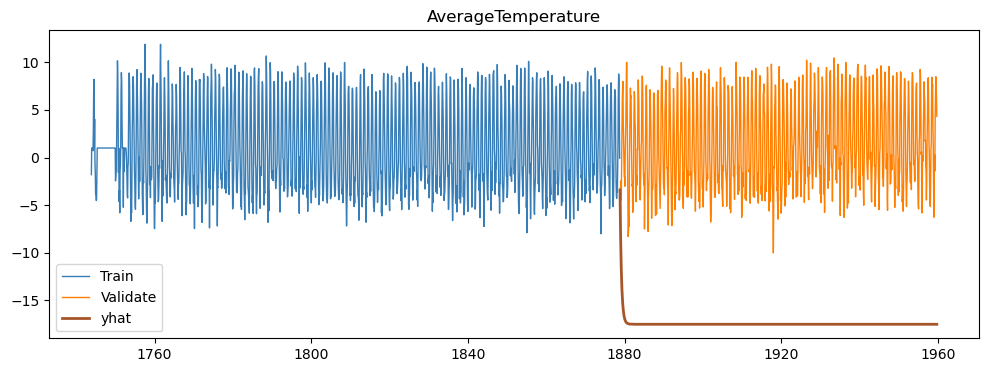

In [124]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [70]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [71]:
eval_df

,model_type,target_var,rmse
0,moving_avg,AverageTemperature,5.0
1,simple_average,AverageTemperature,5.0
2,7_day_moving_avg,AverageTemperature,5.0
3,30_day_moving_avg,AverageTemperature,5.0
4,90_day_moving_avg,AverageTemperature,5.0
5,120_day_moving_avg,AverageTemperature,5.0
6,730_day_moving_avg,AverageTemperature,5.0
7,holts_optimized,AverageTemperature,20.0


In [145]:
hst_temp_fit1 = ExponentialSmoothing(train.AverageTemperature, seasonal_periods=480, trend='add', seasonal='add', damped = True).fit()


/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [146]:
results_temp=pd.DataFrame({'model':['hst_temp_fit1'],
                              'SSE':[hst_temp_fit1.sse]})
results_temp

,model,SSE
0,hst_temp_fit1,2351.744781


In [147]:
yhat_df = pd.DataFrame({'AverageTemperature': hst_temp_fit1.forecast(validate.shape[0])},
                          index=validate.index)
yhat_df

,AverageTemperature
dt,
1878-11-01,-1.763521
1878-12-01,-3.212614
1879-01-01,-2.867703
1879-02-01,-3.682972
1879-03-01,-3.072720
...,...
1959-06-01,7.031079
1959-07-01,8.694168
1959-08-01,8.216851


AverageTemperature -- RMSE: 2


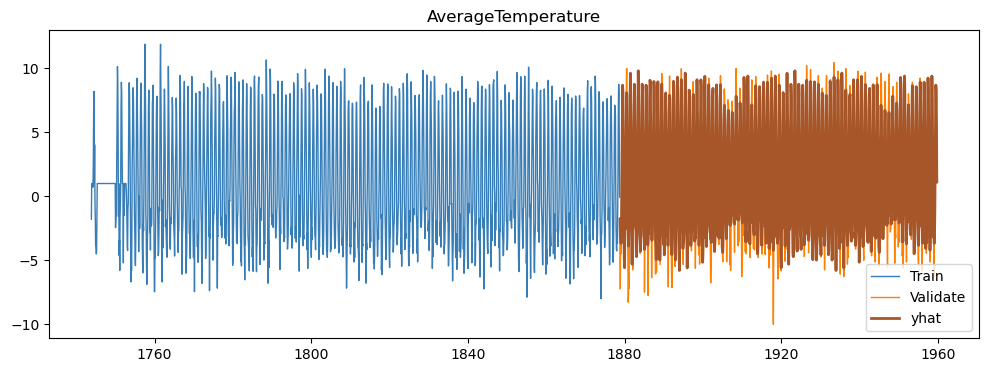

In [148]:
for col in train.columns:
    plot_and_eval(col)

In [149]:
train = iceland_resamp[:train_size]
validate = iceland_resamp[train_size:validate_end_index]
test = iceland_resamp[validate_end_index:]

In [150]:
train.shape, validate.shape, test.shape

((1620, 1), (972, 1), (647, 1))

In [152]:
yhat_df = pd.DataFrame({'AverageTemperature': hst_temp_fit1.forecast(validate.shape[0] + test.shape[0])})
yhat_df

,AverageTemperature
1878-11-01,-1.763521
1878-12-01,-3.212614
1879-01-01,-2.867703
1879-02-01,-3.682972
1879-03-01,-3.072720
...,...
2013-05-01,3.903305
2013-06-01,7.259975
2013-07-01,9.325255
2013-08-01,8.308838


In [153]:
validate.head(1)

,AverageTemperature
dt,
1878-11-01,-3.236


In [154]:
test.head(1)

,AverageTemperature
dt,
1959-11-01,-1.235


In [160]:
yhat_df=yhat_df['1959-11-01':]

In [161]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

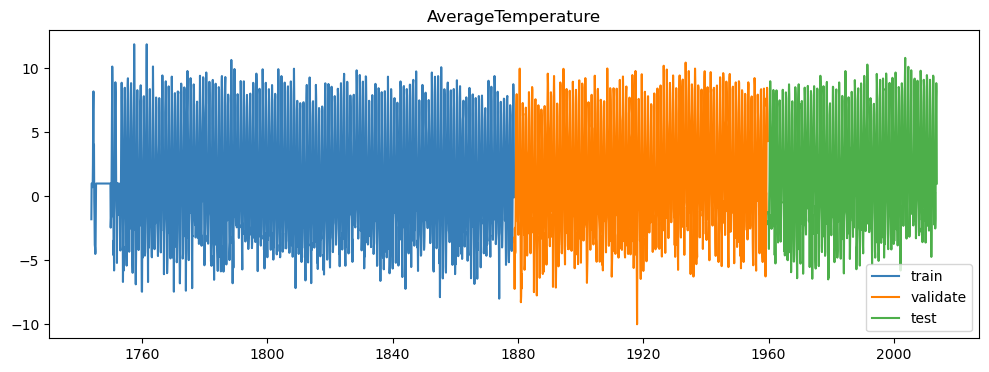

In [181]:

plt.figure(figsize=(12,4))
plt.plot(train['AverageTemperature'], color='#377eb8', label='train')
plt.plot(validate['AverageTemperature'], color='#ff7f00', label='validate')
plt.plot(test['AverageTemperature'], color='#4daf4a',label='test')
plt.legend()
plt.title('AverageTemperature')
plt.show()

In [162]:
rmse_temp_total = sqrt(mean_squared_error(test['AverageTemperature'], yhat_df['AverageTemperature']))



FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-temp total:  1.6547941132177417


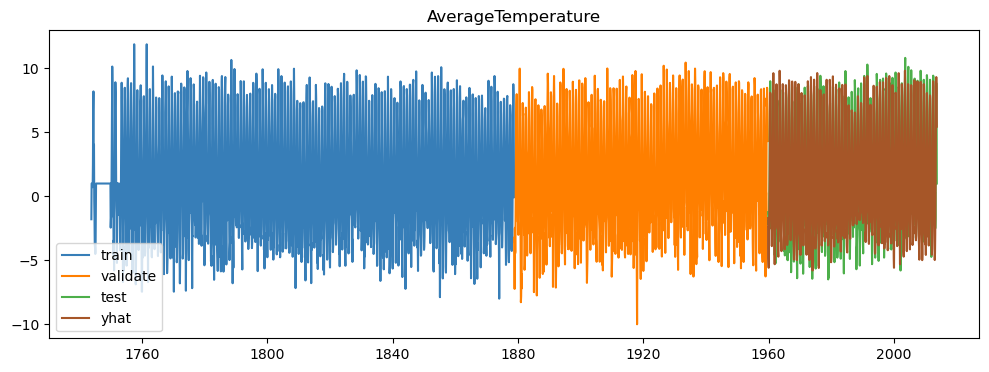

In [164]:
print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-temp total: ', rmse_temp_total)
for col in train.columns:
    final_plot(col)

In [165]:
test.tail(1)

,AverageTemperature
dt,
2013-09-01,1.0


In [175]:
forecast = pd.DataFrame({'AverageTemperature': hst_temp_fit1.forecast(validate.shape[0] + test.shape[0] + 300)})
forecast = forecast['2013':]
forecast

,AverageTemperature
2013-01-01,-4.983685
2013-02-01,-4.450257
2013-03-01,-2.890333
2013-04-01,-0.142186
2013-05-01,3.903305
...,...
2038-05-01,3.152923
2038-06-01,7.137718
2038-07-01,9.406029
2038-08-01,7.802163


In [176]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(validate[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

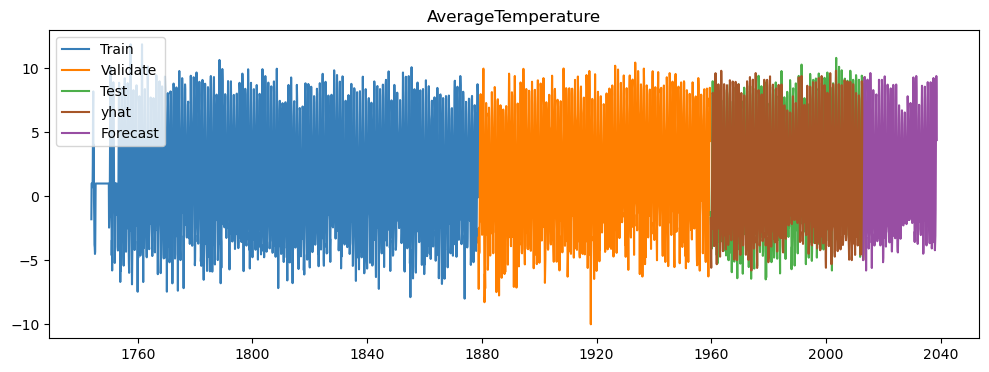

In [177]:
for col in train.columns:
    final_plot(col)